# Data Science and Big Data Project 1: Spotify Music Analysis
## Final Report
**Group 14: Honda Zhang, Jessica Zhu**

[<img src="https://cdn.eventfinda.co.nz/uploads/events/transformed/1039889-469605-34.jpg" width="700"/>](https://cdn.eventfinda.co.nz/uploads/events/transformed/1039889-469605-34.jpg)

## Table of Content
1. [Overview](#Overview)
2. [Data collection & preprocessing](#Data-collection-&-preprocessing)
3. [Country-country similarity](#Country-country-similarity)
4. [Audio feature analysis](#Analysis-Track-Features)
5. [Lyrics analysis](#Lyrics-Analysis)
6. [Popular artists](#Top-Artists)
7. [Summary](#Summary)

## Overview

Music is everywhere, from the peaceful bedtime lullaby to chaotic deathrock. Music has long become the most popular means of entertainment, but besides entertaining, music conveys emotions and knowledge. It is a method of communication in our everyday life. 

Both of our team members have the experience of working in different cultures: China, the United States, Japan, Australia. We found, not surprisingly, people from different cultures listen to different genres of music. More interestingly, we have the stereotype that geographical locations could be one of the determining factors that people like what type of music. 

In this data analysis project, we want to explore the domain of music and determine whether there are patterns in people’s preference of a specific genre of music with various factors (geographical, timing, artists, etc.)

To be more specific, we are expected to answer the following questions through data analysis:

1. Are there any groups of countries that share **similar music taste**? Which country holds a distinctive music preference?
2. Are there any artists **popular in multiple countries**, even if they have different music tastes? For countries prefer a music type, which artists are only popular in these countries?
3. What **characteristics of popular tracks** in a country share? What are the major differences between different types of music?

<div>
<img src="analysis_framework.png" width="700"/>
</div>
<center>Figure 1: Analysis Framework</center>


## Data collection & preprocessing
### 1. Data collection

All the data in this project were scrapped from **Spotify API** and **Genius API**.

In general, our dataset has three components:
- **Weekly top 200 songs from 59 countries (2017-2019)**: 
    - using `top_200_songs_scrapper.py` to scrap weekly top 200 songs from 59 countries and store data from each country as a csv file separately.
- **Audio features** for each song: 
    - using `get_track_features.py` to audio features for all the songs in our dataset from Spotify API. 
    - the result stores in file *audio_features.csv*.
- **Lyrics** for each song (only English songs): 
    - applying `scrap_lyrics.ipynb` to grab lyrics for English songs from Genius API. 
    - the result stores in file *lyrics.csv*.
    
For details about these scrapper, please check the corresponding file accordingly.

### 2. Data preprocessing

In this project, we used the total number of occurance of each song in one country to quantify the popularity, which will be used for evaluating similarity between countries and popularity for artists. Therefore, we first need to preprocess the weekly top 200 songs for each country by:
- counting number of occurance of each songs
- using the count to re-rank the song

In [5]:
## import library
import pandas as pd
import numpy as np
from math import pi
import folium
import json
import glob
import os
from os import path
import spacy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

In [6]:
# helper function: calculate total counts and re-rank songs accordingly
def rank_df(input_path, output_path):
    data = pd.read_csv(input_path)
    # drop redundent rows
    data.drop(data[data['Track Name'] == 'Track Name'].index, inplace = True)
    data.drop(data[data['Position'] == 'position'].index, inplace = True)
    data.drop(data[data['Position'].isnull()].index, inplace=True)
    # change columns data type
    data['Position'] = data['Position'].astype('int32')

    rank_data = data.groupby(['Track Name', 'Artist'], sort=False) \
                    .agg({'region': 'count',
                         'Streams': 'max',
                         'Position': 'min',
                         'spotify_id': 'min'}) \
                    .reset_index() \
                    .sort_values(['region'], ascending=False) \
                    .reset_index()

    # change column name and drop redundant columns
    rank_data = rank_data.drop(columns=['index'])
    rank_data = rank_data.rename(columns={'region': 'Count'})
    rank_data.to_csv(output_path)

In [10]:
# helper function: read all raw data for each country and create re-ranked data file
def read_files():
    for filename in glob.glob('./data/*.csv'):
        input_path = os.path.abspath(filename)
        output_path = './total_rank_data/' + str(os.path.basename(filename))
        rank_df(input_path, output_path)

In [11]:
read_files()

Next, we selected top 200 songs from each country and then uses the `region_mapping.csv` file to change country name from abbreviation to full name.

In [23]:
mapping_df = pd.read_csv('region_mapping.csv', header=None) # read files
countries = mapping_df.values.tolist() # transfer dataframe into list with (abbr, full name) pairs

In [24]:
# read top 200 songs from each country file and aggregate
df_rank = pd.DataFrame()
for country in countries:
    file_name = 'total_rank_data/' + country[0] + '.csv'
    temp = pd.read_csv(file_name)
    famous_song_series = temp[['Track Name', 'spotify_id']][:100]
    famous_song_df = pd.DataFrame({'Name': famous_song_series['Track Name'],\
                                   'spotify_id': famous_song_series['spotify_id'],
                                   'Country': country[1]})
    df_rank = df_rank.append(famous_song_df)

In [25]:
df_rank = df_rank.reset_index()
df_rank = df_rank.rename(columns = {'index':'rank'})
df_rank.head()

,rank,Name,spotify_id,Country
0,0,Crimen,3oqWr0jDWNXxWufNogGREp,Argentina
1,1,Creo,5Bi9Cq5oVFy1OtUgecbegZ,Argentina
2,2,Spaghetti del Rock,6rg1MBZqggsQ5olFGTw0rr,Argentina
3,3,Nunca quise,0ZAJ660VP57lLK4U7NlGOy,Argentina
4,4,Me Gusta,3pMo77B4r1NwwIK78lO4xf,Argentina


In [26]:
# store the new dataframe as a csv file
df_rank.to_csv('top_songs_country.csv')

## Country-country similarity

### 1. Similarity score

To identify countries with similar music taste, we defined **similarity score** as *number of songs showed up both countries' top 200 tracks list*. First, let's calculate the similarity score for each country pairs.

In [28]:
country_matrix_rank = pd.DataFrame(columns=[country[1] for country in countries])

In [29]:
for country in countries:
    score_list = []
    current_temp = df_rank[df_rank['Country'] == country[1]]
    for counterparty in country_matrix_rank.iteritems():
        counterparty_temp = df_rank[df_rank['Country'] == counterparty[0]]
        temp = counterparty_temp.merge(current_temp, left_on='Name', right_on='Name')
        score_list.append(len(temp)/len(current_temp))
    country_matrix_rank.loc[country[1]] = score_list

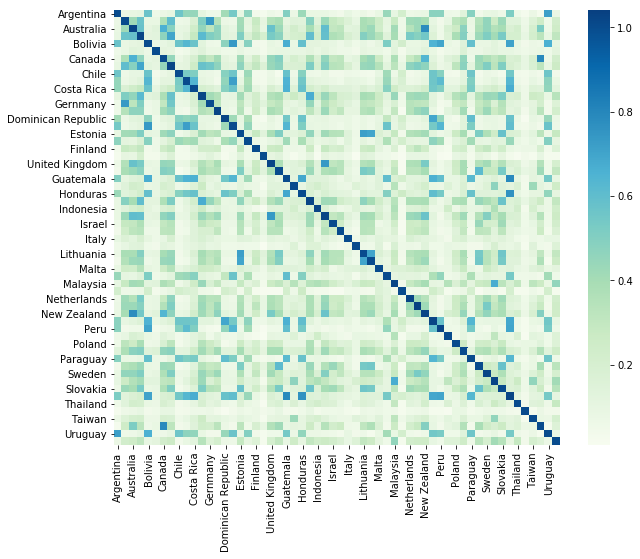

In [33]:
# visualize similarity score matrix
plt.figure(figsize = (10,8))
sns.heatmap(country_matrix_rank, cmap="GnBu")
plt.show()

From the plot above, we noticed that there are some countries have low similarity scores with all the other countries. Therefore, we set a threshold to filter out those unique countries.

In [34]:
# filter country that not similar with other
unique_country = list(country_matrix_rank[country_matrix_rank.sum(axis = 1) < 7].index)

In [35]:
unique_country

['Brazil', 'France', 'Japan', 'Nicaragua', 'Turkey']

From this plot, we can see that some of the countries share similar music tastes. However, it's hard to use the result to group similar countries. Therefore, we tried to use clustering method the find the similar countries.

### 2. K-Means Clustering

In [37]:
# first use one-hot-encoding to create features
enc = OneHotEncoder(handle_unknown='ignore')

In [38]:
ohe_features = enc.fit_transform(np.array(df_rank['Name']).reshape(-1,1)).toarray()

In [39]:
enc.categories_

[array(['#ihanaa', "'Di Na Muli", "'Till I Collapse", ..., '鱗(うろこ)',
        '빨간 맛 Red Flavor', '피카부 Peek-A-Boo'], dtype=object)]

In [40]:
df_ohe = pd.DataFrame(ohe_features)

In [41]:
df_ohe['Country'] = df_rank.reset_index()['Country']

In [42]:
# sum ohe features by country
df_ohe = df_ohe.groupby('Country').sum()

In [43]:
# incorporate ranking information into the one hot encoder
def ohe_rank(df_ohe, df_rank, enc):
    df_ohe_rank = df_ohe.copy()
    ohe_dict = {i:enc.categories_[0][i] for i in df_ohe.columns}
    for country in df_ohe.index:
        for song in df_ohe.columns:
            if df_ohe_rank.loc[country][song] == 1:
                df_ohe_rank.loc[country][song] = 100-df_rank[(df_rank['Country'] == country)&
                                                    (df_rank['Name'] == ohe_dict[song])]['rank'] 
                # use 200-rank becuase we want to give higher rank more importance
    return df_ohe_rank

In [44]:
df_ohe_rank = ohe_rank(df_ohe, df_rank, enc)

In [45]:
df_ohe_rank.head()

,0,1,2,3,4,5,6,7,8,9,...,2121,2122,2123,2124,2125,2126,2127,2128,2129,2130
Country,,,,,,,,,,,,,,,,,,,,,
Argentina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Australia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Austria,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bolivia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
df_ohe_cluster = df_ohe_rank.copy()
df_ohe_cluster.drop(index = unique_country, inplace = True) # change index

In [22]:
# Use silhouette score to find the best number of clusters
best_k = None
best_labels = None
best_score = -1
best_model = None

scores_kmeans = {}

for k in range(2, 21):
    
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans.fit(df_ohe_cluster)
    
    labels = kmeans.labels_
    score = silhouette_score(df_ohe_cluster, labels)
    scores_kmeans[k] = score
    print('k =', k, 'has silhouette score', score)
    
    if score > best_score:
        best_score = score
        best_k = k
        best_model = kmeans
        best_labels = labels

print()
print("Best k = " + str(best_k), 'according to silhouette score')
print()


k = 2 has silhouette score 0.16207400835225955
k = 3 has silhouette score 0.1740694057962407
k = 4 has silhouette score 0.14282014940268797
k = 5 has silhouette score 0.13021231496988062
k = 6 has silhouette score 0.1316554524975035
k = 7 has silhouette score 0.14389069123909745
k = 8 has silhouette score 0.13782269511944467
k = 9 has silhouette score 0.13490663306681597
k = 10 has silhouette score 0.07056829166083886
k = 11 has silhouette score 0.08137760594140614
k = 12 has silhouette score 0.08051802010207512
k = 13 has silhouette score 0.08028491961231327
k = 14 has silhouette score 0.07631151188849945
k = 15 has silhouette score 0.08460402199459437
k = 16 has silhouette score 0.08764684288615278
k = 17 has silhouette score 0.08478498314385624
k = 18 has silhouette score 0.1013682662303677
k = 19 has silhouette score 0.11011744748003013
k = 20 has silhouette score 0.10997419003059183

Best k = 3 according to silhouette score



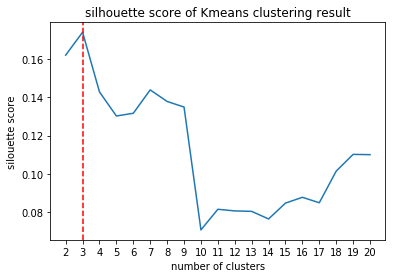

In [23]:
# visualize silhouette score
plt.plot(list(scores_kmeans.keys()), list(scores_kmeans.values()))
plt.axvline(x = best_k, color = 'r', linestyle = '--')
plt.xticks(list(scores_kmeans.keys()))
plt.ylabel('silouette score')
plt.xlabel('number of clusters')
plt.title('silhouette score of Kmeans clustering result')
plt.show()

In [49]:
# use kmeans clustering result to assign countrie into clusters
kmeans = KMeans(n_clusters = best_k, random_state = 0)
kmeans.fit(df_ohe_cluster)
df_ohe_cluster['Cluster'] = kmeans.labels_

In [50]:
df_ohe_cluster['Cluster'].value_counts()

1    29
0    16
2     8
Name: Cluster, dtype: int64

In [99]:
cluster_1 = df_ohe_cluster.groupby('Cluster').get_group(0).index
cluster_1

Index(['Argentina', 'Bolivia', 'Chile', 'Colombia', 'Costa Rica',
       'Dominican Republic', 'Ecuador', 'El Salvador', 'Guatemala', 'Honduras',
       'Mexico', 'Panama', 'Paraguay', 'Peru', 'Spain', 'Uruguay'],
      dtype='object', name='Country')

In [100]:
cluster_2 = df_ohe_cluster.groupby('Cluster').get_group(1).index
cluster_2

Index(['Australia', 'Austria', 'Belgium', 'Canada', 'Czechia', 'Denmark',
       'Estonia', 'Finland', 'Gernmany', 'Greece', 'Hungary', 'Iceland',
       'Ireland', 'Israel', 'Italy', 'Latvia', 'Lithuania', 'Malta',
       'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Portugal', 'Romania',
       'Slovakia', 'Sweden', 'Switzerland', 'United Kingdom', 'United States'],
      dtype='object', name='Country')

In [101]:
cluster_3 = df_ohe_cluster.groupby('Cluster').get_group(2).index
cluster_3

Index(['HongKong', 'Indonesia', 'Malaysia', 'Philippines', 'Singapore',
       'Taiwan', 'Thailand', 'Vietnam'],
      dtype='object', name='Country')

We figured out that most countries within in same cluster are locate in the same continent or speaking the same language. We named these three clusters accrodingly.

In [54]:
cluster_regions = ['South America', 'Europ, North America & Oceania','South & East Asia']

In [55]:
# create seperate dataframe for each cluster
group_0 = df_rank.loc[df_rank['Country'].isin(list(df_ohe_cluster.groupby('Cluster').get_group(0).index))]
group_1 = df_rank.loc[df_rank['Country'].isin(list(df_ohe_cluster.groupby('Cluster').get_group(1).index))]
group_2 = df_rank.loc[df_rank['Country'].isin(list(df_ohe_cluster.groupby('Cluster').get_group(2).index))]

Now let's visualize the similarity score again by arranging countries by clusters.

In [65]:
# create a list of country in the sequence of the cluster
final_country = list(cluster_2) + list(cluster_1) + list(cluster_3) + unique_country
final_matrix = pd.DataFrame(columns=[country for country in final_country])

In [66]:
# recalculate the similarity matrix with label being the cluster sequence
for country in final_country:
    score_list = []
    current_temp = df_rank[df_rank['Country'] == country]
    for counterparty in final_matrix.iteritems():
        counterparty_temp = df_rank[df_rank['Country'] == counterparty[0]]
        temp = counterparty_temp.merge(current_temp, left_on='Name', right_on='Name')
        score_list.append(len(temp)/len(current_temp))
    final_matrix.loc[country] = score_list

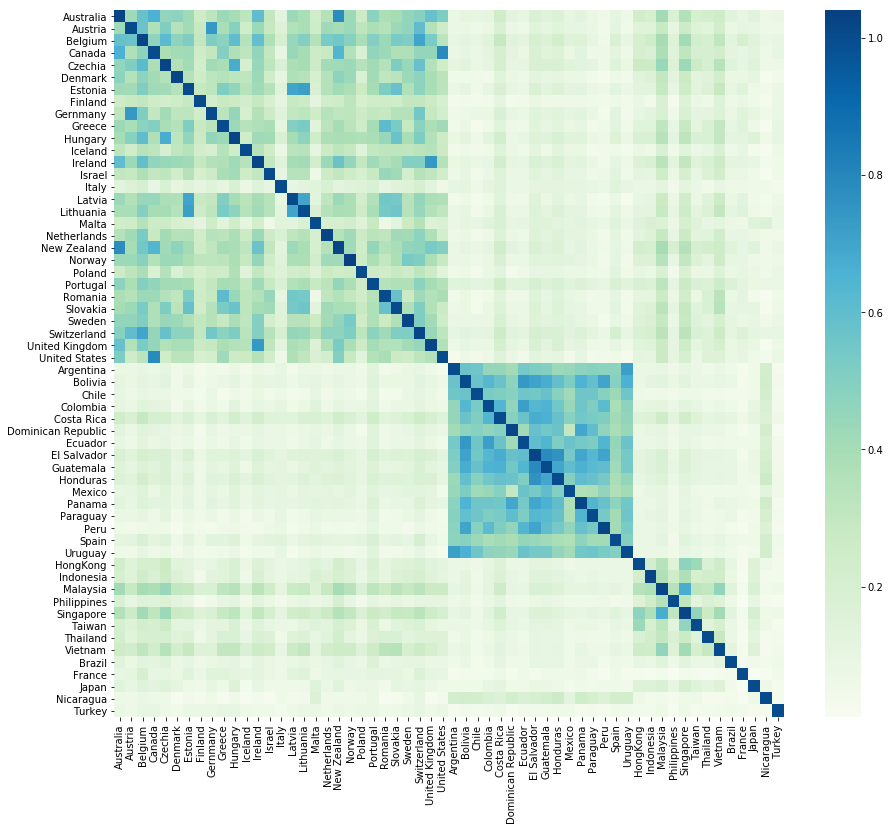

In [67]:
# print out the heatmap for the cluster result
plt.figure(figsize = (15,13))
sns.heatmap(final_matrix, cmap="GnBu")
plt.show()

From the heatmap, we observe the similarity between South American countries is very close. People in South America has the same tase in musicto only South American. While Europe, North America and Oceania shares a medium similar taste of music. Asian has a similar taste but they also in some degree like Europe, North American, and Oceania music.

**Visualization of clustering result**

In [68]:
# import the definition of country
country_geo = 'world-countries.json'
with open(country_geo) as f:
    geo = json.load(f)

append country in each cluster

In [70]:
geo_color = pd.DataFrame({'Name': cluster_1, "Value":1})
geo_color = geo_color.append(pd.DataFrame({'Name': cluster_2, "Value": 2}))
geo_color = geo_color.append(pd.DataFrame({'Name': cluster_3, "Value": 3}))
geo_color = geo_color.append(pd.DataFrame({'Name': unique_country, "Value": 4}))
geo_color = geo_color.reset_index(drop=True)
# the United States in the dataframe is in another name as "United States of America" in the
# geo file, change the name in order to get the correct visualization
geo_color.replace("United States", "United States of America", inplace=True) 

In [71]:
# Setup a folium map at a high-level zoom 
m = folium.Map(location=[0, 0], zoom_start=1.5)
# choropleth maps bind Pandas Data Frames and json geometries. 
# This allows us to quickly visualize data combinations
folium.Choropleth(geo_data=geo, data=geo_color, name="choropleth",
             columns=['Name', "Value"],
             key_on='feature.properties.name',
             fill_color='PiYG', fill_opacity=1, line_opacity=0.5).add_to(m)

Save the visualization as an HTML file, and show the visualization

In [98]:
m.save('globalmap.html')
m

From the visualization, it is obvious that except for 5 of the unique countries. The cluster is depend on the **geographic continents**. With South America in one cluster. North America, Europe, and Oceania in another cluster, and Asian countries in the third cluster. There are also exceptions which is Spain, which is a European country but share similar music taste as South American. Black region stands for data not available (Not major user of Spotify)

## Analysis Track Features
[Spotify](https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features/) provide a list of features describing audio. Below are the description of all the useful features in the dataset.

- **acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
- **danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
- **energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
- **instrumentalness**: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
- **key**: The key the track is in. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.
- **liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
- **loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.
- **speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
- **tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
- **valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

In [73]:
# read files
track_features = pd.read_csv('audio_features.csv')

In [75]:
track_features.head()

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0,0.799,0.722,7,-5.051,1,0.0387,0.35900,0.000000,0.178,0.880,128.012,audio_features,2EhvCzRw0C7anZHsj284oX,spotify:track:2EhvCzRw0C7anZHsj284oX,https://api.spotify.com/v1/tracks/2EhvCzRw0C7a...,https://api.spotify.com/v1/audio-analysis/2Ehv...,176906,4
1,1,0.553,0.964,0,-6.710,1,0.0568,0.00221,0.017600,0.060,0.530,133.935,audio_features,6BI4NrjNsQfac2erXVjSVf,spotify:track:6BI4NrjNsQfac2erXVjSVf,https://api.spotify.com/v1/tracks/6BI4NrjNsQfa...,https://api.spotify.com/v1/audio-analysis/6BI4...,220177,4
2,2,0.668,0.816,9,-3.708,0,0.0322,0.03110,0.000025,0.195,0.550,129.975,audio_features,3CZoTwEuhvrokhej4VAo0Q,spotify:track:3CZoTwEuhvrokhej4VAo0Q,https://api.spotify.com/v1/tracks/3CZoTwEuhvro...,https://api.spotify.com/v1/audio-analysis/3CZo...,253027,4
3,3,0.547,0.881,4,-5.994,0,0.3100,0.11100,0.000000,0.386,0.440,86.628,audio_features,7CbkW1lLxOM5D6YWTnzknv,spotify:track:7CbkW1lLxOM5D6YWTnzknv,https://api.spotify.com/v1/tracks/7CbkW1lLxOM5...,https://api.spotify.com/v1/audio-analysis/7Cbk...,166486,4
4,4,0.639,0.745,0,-3.631,1,0.0416,0.11000,0.000000,0.131,0.356,139.993,audio_features,4ffYbqNOSn01NHOmQGJEKT,spotify:track:4ffYbqNOSn01NHOmQGJEKT,https://api.spotify.com/v1/tracks/4ffYbqNOSn01...,https://api.spotify.com/v1/audio-analysis/4ffY...,193948,4


In [74]:
track_features.describe()

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,50061.00000,50061.000000,50061.000000,50061.000000,50061.000000,50061.000000,50061.000000,50061.000000,50061.000000,50061.000000,50061.000000,50061.000000,5.006100e+04,50061.000000
mean,25030.00000,0.667457,0.651180,5.361819,-6.698949,0.552446,0.129174,0.258231,0.014247,0.176977,0.501946,121.571284,2.094989e+05,3.967120
std,14451.51025,0.144104,0.170259,3.620014,2.564901,0.497247,0.119534,0.247293,0.089112,0.139490,0.219870,28.415323,5.072856e+04,0.301477
min,0.00000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+03,0.000000
25%,12515.00000,0.574000,0.544000,2.000000,-7.942000,0.000000,0.041700,0.056100,0.000000,0.095600,0.333000,99.023000,1.801970e+05,4.000000
50%,25030.00000,0.684000,0.668000,6.000000,-6.337000,1.000000,0.074600,0.175000,0.000000,0.122000,0.497000,120.039000,2.044270e+05,4.000000
75%,37545.00000,0.774000,0.778000,9.000000,-5.024000,1.000000,0.187000,0.398000,0.000035,0.210000,0.671000,140.003000,2.324400e+05,4.000000
max,50060.00000,0.983000,0.999000,11.000000,1.634000,1.000000,0.966000,0.995000,0.987000,0.990000,0.982000,232.690000,2.147004e+06,5.000000


In [76]:
# join audio feature with rank songs dataframe
df_rank_audio = pd.merge(df_rank, track_features, how = 'left', left_on = 'spotify_id', right_on = 'id')

In [78]:
# merge country rank dataframe with audio features
group_0_audio = pd.merge(group_0, track_features, how = 'left', left_on = 'spotify_id', right_on = 'id')
group_1_audio = pd.merge(group_1, track_features, how = 'left', left_on = 'spotify_id', right_on = 'id')
group_2_audio = pd.merge(group_2, track_features, how = 'left', left_on = 'spotify_id', right_on = 'id')

There are some columns will not be used in our EDA analysis, we create a list to contain useful columns

In [79]:
hist_columns = list(track_features.columns[:12]) + list(track_features.columns[-2:-1])
hist_columns.remove('mode')
hist_columns.remove('Unnamed: 0')
hist_columns.remove('key')

Let's visualize disbribution for each cluster regarding these audio features.

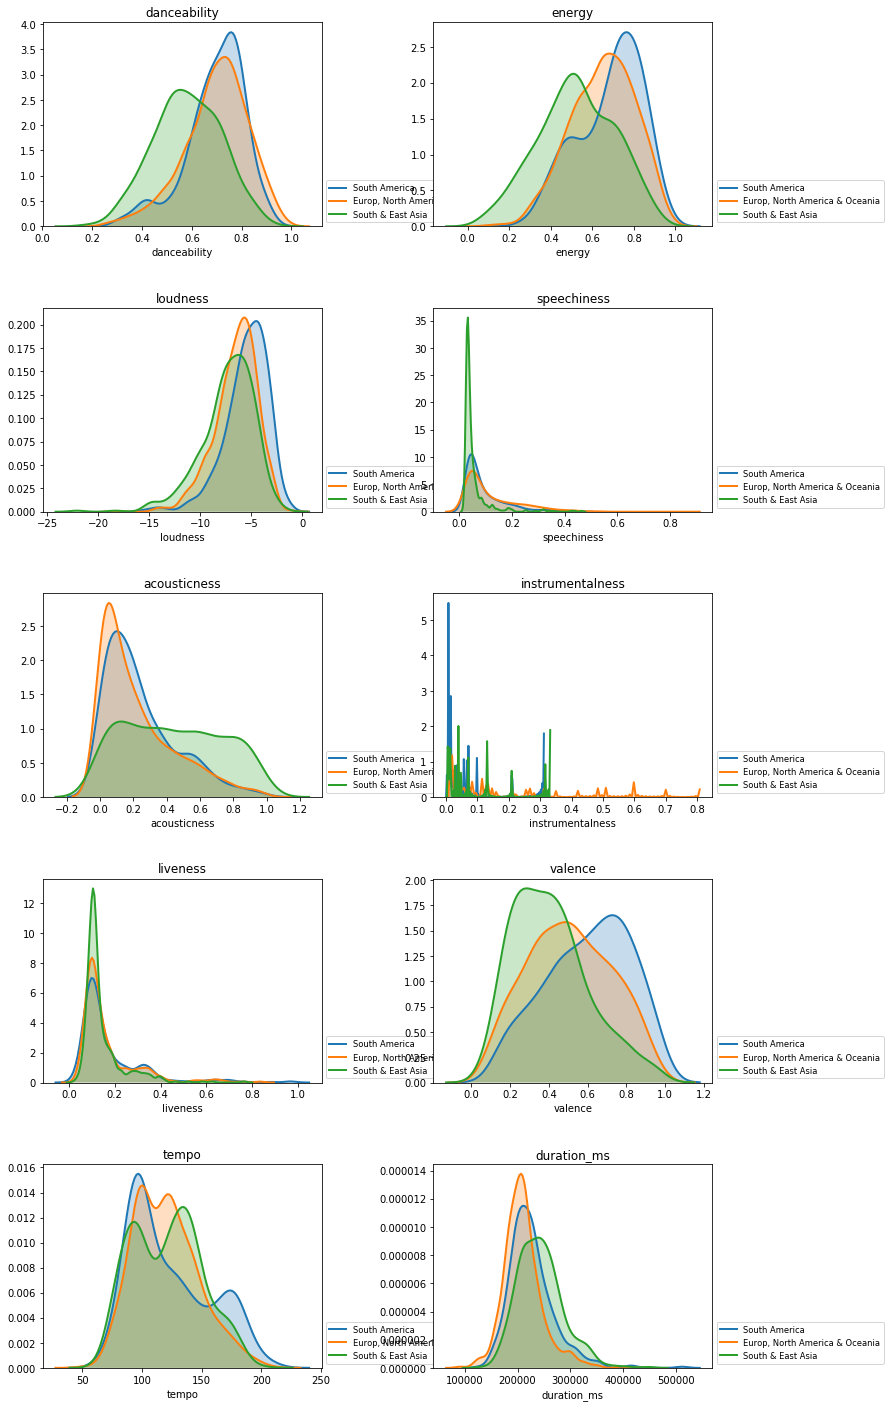

In [80]:
fig = plt.figure(figsize = (12,30))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(0, 10):
    ax = fig.add_subplot(6, 2, i+1)
    l1=sns.distplot(group_0_audio.groupby('spotify_id').max()[hist_columns[i]], 
                    hist = False, kde = True, 
                    kde_kws = {'shade': True, 'linewidth': 2},label = cluster_regions[0])
    l2=sns.distplot(group_1_audio.groupby('spotify_id').max()[hist_columns[i]], 
                    hist = False, kde = True, 
                    kde_kws = {'shade': True, 'linewidth': 2},label = cluster_regions[1])
    l3=sns.distplot(group_2_audio.groupby('spotify_id').max()[hist_columns[i]], 
                    hist = False, kde = True, 
                    kde_kws = {'shade': True, 'linewidth': 2},label = cluster_regions[2])
    ax.set_title(hist_columns[i])
    ax.legend(fontsize = 'small', loc = 'lower left', bbox_to_anchor=(1, 0))

plt.show()

From the above plot, we found out that countries from each cluster showed differenece in terms of `danceability, energy, acousticness, liveness and happiness`. Then, let's create a spider plot to combine these five features in one single plot.

In [81]:
radar_list = hist_columns
radar_list.remove('loudness')
radar_list.remove('tempo')
radar_list.remove('duration_ms')
radar_list.remove('instrumentalness')
radar_list.remove('speechiness')

In [82]:
spider = pd.DataFrame(columns = hist_columns)
spider = spider.append({key:value for key,value in zip(group_0_audio[radar_list].mean().index, 
                                list(group_0_audio.groupby('spotify_id').max()[radar_list].mean()))},ignore_index=True)
spider = spider.append({key:value for key,value in zip(group_1_audio[radar_list].mean().index, 
                                list(group_1_audio.groupby('spotify_id').max()[radar_list].mean()))},ignore_index=True)
spider = spider.append({key:value for key,value in zip(group_2_audio[radar_list].mean().index, 
                                list(group_2_audio.groupby('spotify_id').max()[radar_list].mean()))},ignore_index=True)
spider

,danceability,energy,acousticness,liveness,valence
0,0.694721,0.684781,0.244168,0.173410,0.602943
1,0.697443,0.650528,0.224218,0.165908,0.507809
2,0.580928,0.522884,0.442878,0.142171,0.408972


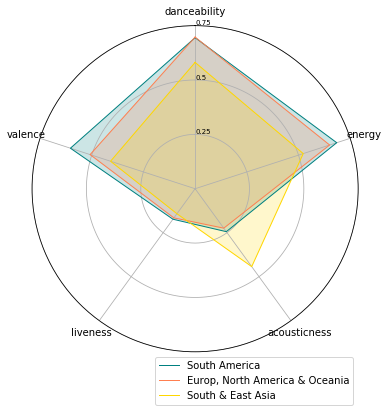

In [84]:
# ------- PART 1: Create background

# number of variable
categories=list(spider)
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
fig = plt.figure(figsize = (12,6))

ax = fig.add_subplot(1,1,1, polar=True)

 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.25,0.5,0.75], ["0.25","0.5","0.75"], color="black", size=7)
plt.ylim(0,0.75)
 
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable
 
values=spider.loc[0].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label=cluster_regions[0], color = 'teal')
ax.fill(angles, values, 'teal', alpha=0.2)
 
values=spider.loc[1].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label=cluster_regions[1], color = 'coral')
ax.fill(angles, values, 'coral', alpha=0.2)

values=spider.loc[2].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label=cluster_regions[2], color = 'gold')
ax.fill(angles, values, 'gold', alpha=0.2)
plt.legend(loc = 'upper right',bbox_to_anchor=(1, 0))

plt.show()

As we can see from the above plot, Asian prefer relaxing music while South and North American both like songs that are more energetic.

Next, let's have a look at key of tracks.

In [86]:
keys = {'C': 0, 'C-sharp': 1, 'D': 2, 'D-sharp': 3, 'E': 4, 'F': 5, 'F-sharp': 6, 'G': 7, 'G-sharp': 8, 
       'A': 10, 'B-flat': 11, 'B': 12}

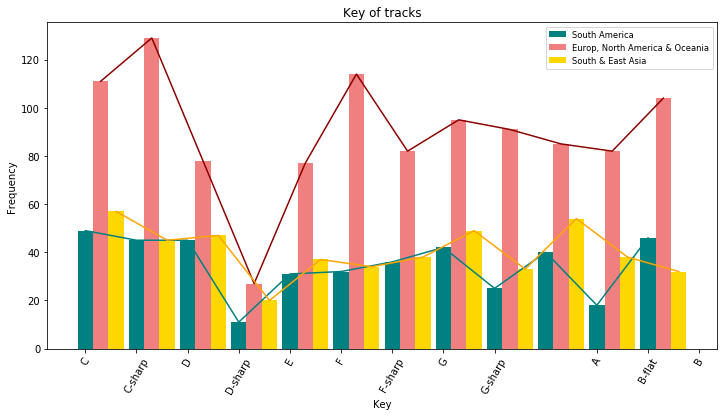

In [87]:
plt.figure(figsize = (12,6))
plt.bar(group_0_audio.groupby('spotify_id').max()['key'].value_counts().sort_index().index, 
        group_0_audio.groupby('spotify_id').max()['key'].value_counts().sort_index(), width = 0.3,
        color = 'teal', label = cluster_regions[0])
plt.plot(group_0_audio.groupby('spotify_id').max()['key'].value_counts().sort_index().index, 
        group_0_audio.groupby('spotify_id').max()['key'].value_counts().sort_index(),
        color = 'teal', label = '')

plt.bar(group_1_audio.groupby('spotify_id').max()['key'].value_counts().sort_index().index + 0.3, 
        group_1_audio.groupby('spotify_id').max()['key'].value_counts().sort_index(), width = 0.3,
        color = 'lightcoral', label = cluster_regions[1])
plt.plot(group_1_audio.groupby('spotify_id').max()['key'].value_counts().sort_index().index+ 0.3, 
        group_1_audio.groupby('spotify_id').max()['key'].value_counts().sort_index(),
        color = 'darkred', label = '')

plt.bar(group_2_audio.groupby('spotify_id').max()['key'].value_counts().sort_index().index + 0.6, 
        group_2_audio.groupby('spotify_id').max()['key'].value_counts().sort_index(), width = 0.3,
        color = 'gold', label = cluster_regions[2])
plt.plot(group_2_audio.groupby('spotify_id').max()['key'].value_counts().sort_index().index+ 0.6, 
        group_2_audio.groupby('spotify_id').max()['key'].value_counts().sort_index(),
        color = 'orange', label = '')

plt.title('Key of tracks')
plt.xticks(list(keys.values()),list(keys.keys()), rotation = 60)
plt.xlabel('Key')
plt.ylabel('Frequency')
plt.legend(fontsize = 'small')
plt.show()

Clearly, C and C-sharp are the most popular keys around the world while D-sharp is the least popular keys. Then, let's have a look at the most popular songs writen in these keys.

In [91]:
# C
df_rank_audio[df_rank_audio['key'] == 1].sort_values(by = 'rank').head()

,rank,Name,spotify_id,Country,Unnamed: 0,danceability,energy,key,loudness,mode,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
2700,0,Mr. Brightside,7d8GetOsjbxYnlo6Y9e5Kw,Ireland,8018,0.352,0.928,1,-3.710,1,...,0.0987,0.239,148.026,audio_features,7d8GetOsjbxYnlo6Y9e5Kw,spotify:track:7d8GetOsjbxYnlo6Y9e5Kw,https://api.spotify.com/v1/tracks/7d8GetOsjbxY...,https://api.spotify.com/v1/audio-analysis/7d8G...,222107,4
3700,0,Me Rehúso,6De0lHrwBfPfrhorm9q1Xl,Nicaragua,44424,0.744,0.804,1,-6.327,1,...,0.0494,0.426,104.823,audio_features,6De0lHrwBfPfrhorm9q1Xl,spotify:track:6De0lHrwBfPfrhorm9q1Xl,https://api.spotify.com/v1/tracks/6De0lHrwBfPf...,https://api.spotify.com/v1/audio-analysis/6De0...,205715,4
3400,0,Shape of You,7qiZfU4dY1lWllzX7mPBI3,Malta,45366,0.825,0.652,1,-3.183,0,...,0.0931,0.931,95.977,audio_features,7qiZfU4dY1lWllzX7mPBI3,spotify:track:7qiZfU4dY1lWllzX7mPBI3,https://api.spotify.com/v1/tracks/7qiZfU4dY1lW...,https://api.spotify.com/v1/audio-analysis/7qiZ...,233713,4
800,0,Me Rehúso,6De0lHrwBfPfrhorm9q1Xl,Chile,44424,0.744,0.804,1,-6.327,1,...,0.0494,0.426,104.823,audio_features,6De0lHrwBfPfrhorm9q1Xl,spotify:track:6De0lHrwBfPfrhorm9q1Xl,https://api.spotify.com/v1/tracks/6De0lHrwBfPf...,https://api.spotify.com/v1/audio-analysis/6De0...,205715,4
2500,0,Shape of You,7qiZfU4dY1lWllzX7mPBI3,Hungary,45366,0.825,0.652,1,-3.183,0,...,0.0931,0.931,95.977,audio_features,7qiZfU4dY1lWllzX7mPBI3,spotify:track:7qiZfU4dY1lWllzX7mPBI3,https://api.spotify.com/v1/tracks/7qiZfU4dY1lW...,https://api.spotify.com/v1/audio-analysis/7qiZ...,233713,4


In [89]:
# C-sharp
df_rank_audio[df_rank_audio['key'] == 2].sort_values(by = 'rank').head()

,rank,Name,spotify_id,Country,Unnamed: 0,danceability,energy,key,loudness,mode,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
3000,0,Veleno 6,7GfXjqXD9aBvDoBdZ7EwPH,Italy,36428,0.753,0.846,2,-6.846,1,...,0.290,0.636,147.871,audio_features,7GfXjqXD9aBvDoBdZ7EwPH,spotify:track:7GfXjqXD9aBvDoBdZ7EwPH,https://api.spotify.com/v1/tracks/7GfXjqXD9aBv...,https://api.spotify.com/v1/audio-analysis/7GfX...,205126,4
3500,0,Adiós Amor,0HhtLyMxtbpaZon5A8OQU6,Mexico,24250,0.622,0.439,2,-6.447,1,...,0.310,0.714,89.066,audio_features,0HhtLyMxtbpaZon5A8OQU6,spotify:track:0HhtLyMxtbpaZon5A8OQU6,https://api.spotify.com/v1/tracks/0HhtLyMxtbpa...,https://api.spotify.com/v1/audio-analysis/0Hht...,199320,4
1,1,Creo,5Bi9Cq5oVFy1OtUgecbegZ,Argentina,43567,0.382,0.912,2,-2.898,1,...,0.233,0.560,187.941,audio_features,5Bi9Cq5oVFy1OtUgecbegZ,spotify:track:5Bi9Cq5oVFy1OtUgecbegZ,https://api.spotify.com/v1/tracks/5Bi9Cq5oVFy1...,https://api.spotify.com/v1/audio-analysis/5Bi9...,289760,4
1301,1,For Evigt,59fQzvSv0wPQorW2Bh0pns,Denmark,43656,0.506,0.893,2,-3.896,1,...,0.118,0.415,146.971,audio_features,59fQzvSv0wPQorW2Bh0pns,spotify:track:59fQzvSv0wPQorW2Bh0pns,https://api.spotify.com/v1/tracks/59fQzvSv0wPQ...,https://api.spotify.com/v1/audio-analysis/59fQ...,283367,4
3401,1,Despacito (Featuring Daddy Yankee),4aWmUDTfIPGksMNLV2rQP2,Malta,9025,0.660,0.786,2,-4.757,1,...,0.112,0.846,177.833,audio_features,4aWmUDTfIPGksMNLV2rQP2,spotify:track:4aWmUDTfIPGksMNLV2rQP2,https://api.spotify.com/v1/tracks/4aWmUDTfIPGk...,https://api.spotify.com/v1/audio-analysis/4aWm...,228200,4


In [319]:
# D-sharp
df_rank_audio[df_rank_audio['key'] == 4].sort_values(by = 'rank').head()

,rank,Name,spotify_id,Country,Unnamed: 0,danceability,energy,key,loudness,mode,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0,Crimen,3oqWr0jDWNXxWufNogGREp,Argentina,21845,0.537,0.502,4,-8.406,1,...,0.199,0.288,80.511,audio_features,3oqWr0jDWNXxWufNogGREp,spotify:track:3oqWr0jDWNXxWufNogGREp,https://api.spotify.com/v1/tracks/3oqWr0jDWNXx...,https://api.spotify.com/v1/audio-analysis/3oqW...,232027,4
4800,0,Don't Stop Believin',4bHsxqR3GMrXTxEPLuK5ue,Sweden,16504,0.500,0.748,4,-9.072,1,...,0.447,0.514,118.852,audio_features,4bHsxqR3GMrXTxEPLuK5ue,spotify:track:4bHsxqR3GMrXTxEPLuK5ue,https://api.spotify.com/v1/tracks/4bHsxqR3GMrX...,https://api.spotify.com/v1/audio-analysis/4bHs...,250987,4
2601,1,Seperti Yang Kau Minta,0przIlLCg6sRuRUBEUginM,Indonesia,2253,0.507,0.471,4,-6.566,1,...,0.124,0.172,85.426,audio_features,0przIlLCg6sRuRUBEUginM,spotify:track:0przIlLCg6sRuRUBEUginM,https://api.spotify.com/v1/tracks/0przIlLCg6sR...,https://api.spotify.com/v1/audio-analysis/0prz...,289667,4
5301,1,Rüyalarda Buruşmuşum,4cQSOn9oP0MiM7BgiRngFk,Turkey,44291,0.658,0.431,4,-8.708,1,...,0.161,0.458,114.971,audio_features,4cQSOn9oP0MiM7BgiRngFk,spotify:track:4cQSOn9oP0MiM7BgiRngFk,https://api.spotify.com/v1/tracks/4cQSOn9oP0Mi...,https://api.spotify.com/v1/audio-analysis/4cQS...,211534,4
2301,1,不該,7LyCtbxher5m97MImn5M3l,HongKong,43840,0.441,0.619,4,-6.609,1,...,0.118,0.187,75.027,audio_features,7LyCtbxher5m97MImn5M3l,spotify:track:7LyCtbxher5m97MImn5M3l,https://api.spotify.com/v1/tracks/7LyCtbxher5m...,https://api.spotify.com/v1/audio-analysis/7LyC...,290133,4


If you interested in how these typical songs written in each key, you can click below links to try:
- [Shape of you](https://www.youtube.com/watch?v=JGwWNGJdvx8) by Ed Sheeran (C)
- [Despacito](https://www.youtube.com/watch?v=kJQP7kiw5Fk) by Luis Fonsi (C-sharp)
- [Crimen](https://www.youtube.com/watch?v=uLIs0j2WnlM) by Gustavo Cerati (D-sharp)

## Lyrics Analysis

In this part, we will conduct basic text analysis on lyrics. Please notice that, here we only analyze English songs because currently Genuis API only provide lyrics in English.

In [92]:
# read files
lyrics = pd.read_csv('lyrics.csv')

In [93]:
lyrics.head()

,Unnamed: 0,Track Name,Artist,spotify_id,lyrics
0,0,Closer (feat. Halsey),The Chainsmokers,7BKLCZ1jbUBVqRi2FVlTVw,"\n\n2014\n""#SELFIE""\n\n2016\n""Roses"" (feat. RO..."
1,1,Say You Won't Let Go,James Arthur,5uCax9HTNlzGybIStD3vDh,\n\n[Verse 1]\nI remember when you were all mi...
2,2,Photograph,Ed Sheeran,6fxVffaTuwjgEk5h9QyRjy,"\n\n[Verse 1]\nLoving can hurt, loving can hur..."
3,3,A Thousand Years,Christina Perri,6lanRgr6wXibZr8KgzXxBl,\n\n[Instrumental]\n\n
4,4,Faded,Alan Walker,698ItKASDavgwZ3WjaWjtz,\n\n[Verse]\nYou were the shadow to my light\n...


In [94]:
# total number songs
len(lyrics)

45469

In [95]:
# preprocessing text
nlp = spacy.load('en', disable=['ner'], max_length = 1000000000)

In [ ]:
corpus = [nlp(text) for text in list(lyrics['lyrics'])]

In [ ]:
# create tokenized text and store nous, verb, adverbs seperately
corpus_tokens, verbs, nouns, adverbs = [],[],[],[]
 
for doc in corpus:
    tokens,verb, noun, adverb = [],[],[],[]
    for token in doc:
        if token.lemma_ == "-PRON-":
            lemma = token.text
        else:
            lemma = token.lemma_
        
        if token.pos_ == r'VERB':
            verb.append(lemma)
        elif token.pos_ == r'NOUN':
            noun.append(lemma)
        elif token.pos_ == 'ADV':
            adverb.append(lemma)
        
        tokens.append(lemma)
            
    verbs.append(verb)
    nouns.append(noun)
    adverbs.append(adverb)
    corpus_tokens.append(tokens)         

In [105]:
lyrics['token'] = corpus_tokens
lyrics['nouns'] = nouns
lyrics['verbs'] = verbs
lyrics['adverbs'] = adverbs

In [106]:
lyrics.head(3)

,Unnamed: 0,Track Name,Artist,spotify_id,lyrics,token,nouns,verbs,adverbs
0,0,Closer (feat. Halsey),The Chainsmokers,7BKLCZ1jbUBVqRi2FVlTVw,"\n\n2014\n""#SELFIE""\n\n2016\n""Roses"" (feat. RO...","[\n\n, 2014, \n, "", #, selfie, "", \n\n, 2016, ...","[feat, feat, feat, feat, fire, feat, something]","[do, let, know, set]","[not, just]"
1,1,Say You Won't Let Go,James Arthur,5uCax9HTNlzGybIStD3vDh,\n\n[Verse 1]\nI remember when you were all mi...,"[\n\n, [, verse, 1, ], \n, I, remember, when, ...","[verse, mine, front, eye, what, fire, hand, ni...","[remember, be, watch, change, can, say, be, be...","[when, now, not, now, not, away, not, not, til..."
2,2,Photograph,Ed Sheeran,6fxVffaTuwjgEk5h9QyRjy,"\n\n[Verse 1]\nLoving can hurt, loving can hur...","[\n\n, [, verse, 1, ], \n, loving, can, hurt, ...","[verse, thing, thing, love, photograph, memory...","[can, hurt, love, can, hurt, be, know, get, kn...","[sometimes, when, hard, sometimes, where, neve..."


In [107]:
# combine lyrics with rank data to get seperate dataframe for each cluster
group_0_lyrics = pd.merge(group_0, lyrics[['spotify_id','token','nouns','verbs','adverbs']], 
                          how = 'left', left_on = 'spotify_id', right_on = 'spotify_id')
group_1_lyrics = pd.merge(group_1, lyrics[['spotify_id','token','nouns','verbs','adverbs']], 
                          how = 'left', left_on = 'spotify_id', right_on = 'spotify_id')
group_2_lyrics = pd.merge(group_2, lyrics[['spotify_id','token','nouns','verbs','adverbs']], 
                          how = 'left', left_on = 'spotify_id', right_on = 'spotify_id')

In [108]:
group_0_lyrics.head()

,rank,Name,spotify_id,Country,token,nouns,verbs,adverbs
0,0,Crimen,3oqWr0jDWNXxWufNogGREp,Argentina,"[\n\n, [, letra, de, "", crimen, "", ], \n\n, [,...","[espera, no, degradé, que, perdí, cosa, puedo,...","[vos, llama, vez, sé, sé, sé]","[agotó, nada, acosté, no, olvido, no, olvido, ..."
1,1,Creo,5Bi9Cq5oVFy1OtUgecbegZ,Argentina,"[\n\n, el, fuego, ma, soberbio, que, la, vida,...","[fuego, ma, soberbio, vida, dar, razone, parar...","[call, encontraste, oyendo, sueño, tu, vez, ve...",[]
2,2,Spaghetti del Rock,6rg1MBZqggsQ5olFGTw0rr,Argentina,"[\n\n, [, letra, de, "", spaghetti, del, rock, ...","[motor, viejo, este, amor, que, hostil, tiempo...","[momia, ambición, ficción, momia]",[paz]
3,3,Nunca quise,0ZAJ660VP57lLK4U7NlGOy,Argentina,"[\n\n, [, letra, de, "", viviendo, con, él, "", ...","[con, gana, verte, aquella, vez, confesaste, d...","[desde, tortura, iba, escuchándote, iba, vez, ...",[siente]
4,4,Me Gusta,3pMo77B4r1NwwIK78lO4xf,Argentina,"[\n\n, en, la, noche, de, la, noche, \n, cuand...","[noche, noche, dormía, era, mas, polenta, era,...","[gallo, hizo, cuerpo, dejan, espié, lo, garpé,...",[no]


In [109]:
# create a list of stopwords that would be removed from wordcloud
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
spacy_stopwords.add('PRON')
spacy_stopwords.add('oh')
spacy_stopwords.add('yeah')
spacy_stopwords.add('que')
spacy_stopwords.add('che')
spacy_stopwords.add('la')
spacy_stopwords.add('el')
spacy_stopwords.add('eh')
spacy_stopwords.add('ooh')
spacy_stopwords.add('doo')
spacy_stopwords.add('en')
spacy_stopwords.add('na')
spacy_stopwords.add('yo')
spacy_stopwords.add('chorus')
spacy_stopwords.add('pre')
spacy_stopwords.add('li')
spacy_stopwords.add('di')
spacy_stopwords.add('un')
spacy_stopwords.add('yeh')
spacy_stopwords.add('verse')
spacy_stopwords.add('il')
spacy_stopwords.add('non')
spacy_stopwords.add('mi')
spacy_stopwords.add('uh')
spacy_stopwords.add('ma')
spacy_stopwords.add('da')
spacy_stopwords.add('de')
spacy_stopwords.add('like')
spacy_stopwords.add('hol')
spacy_stopwords.add('doo')
spacy_stopwords.add('thunder')

With out dataset ready, we'll start to create word cloud for each cluter.

In [110]:
# create a string for all the nouns in group 0 to prepare for wordcloud
group_0_nouns = [word for sublist in list(group_0_lyrics['nouns']) for word in sublist]
group_0_nouns = ' '.join(group_0_nouns)

In [111]:
# read shape the map for wordcloud
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
south_america_mask = np.array(Image.open(path.join(d, 'map/south_america_snap.png')))

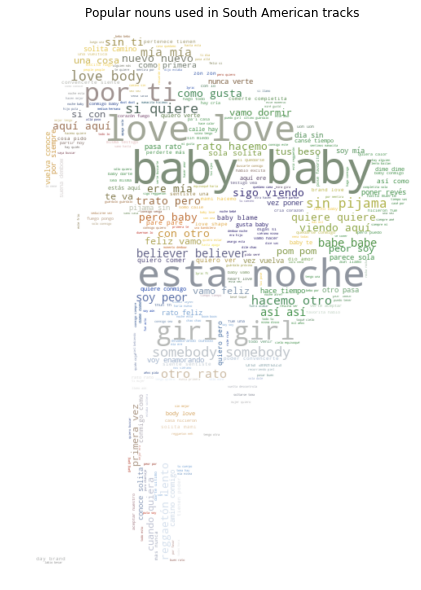

In [112]:
wc = WordCloud(background_color="white", max_words=400, mask=south_america_mask,
        stopwords=spacy_stopwords, max_font_size = 70)
wc.generate(group_0_nouns)
image_colors = ImageColorGenerator(south_america_mask)

plt.figure(figsize = (10,10))
plt.axis("off")
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.title('Popular nouns used in South American tracks')
plt.show()

In [124]:
group_1_nouns = [word for sublist in list(group_1_lyrics['nouns']) for word in sublist]
group_1_nouns = ' '.join(group_1_nouns)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
europe_mask = np.array(Image.open(path.join(d, 'map/europe_america_new.png')))

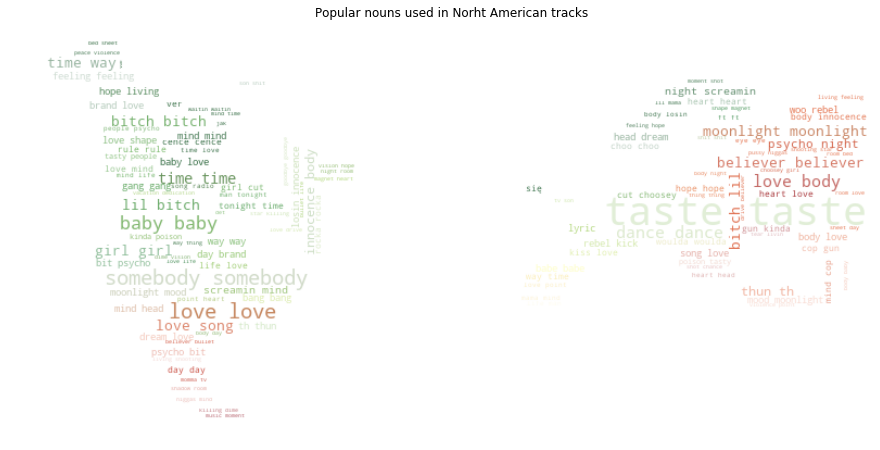

In [114]:
wc = WordCloud(background_color="white", max_words=800, mask=europe_mask,
        stopwords=spacy_stopwords, max_font_size = 80)
wc.generate(group_1_nouns)
image_colors = ImageColorGenerator(europe_mask)

plt.figure(figsize = (15,10))
plt.axis("off")
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.title('Popular nouns used in Norht American tracks')
plt.show()

In [115]:
group_2_nouns = [word for sublist in list(group_2_lyrics['nouns']) for word in sublist]
group_2_nouns = ' '.join(group_2_nouns)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
south_asia_mask = np.array(Image.open(path.join(d, 'map/south_asia.png')))

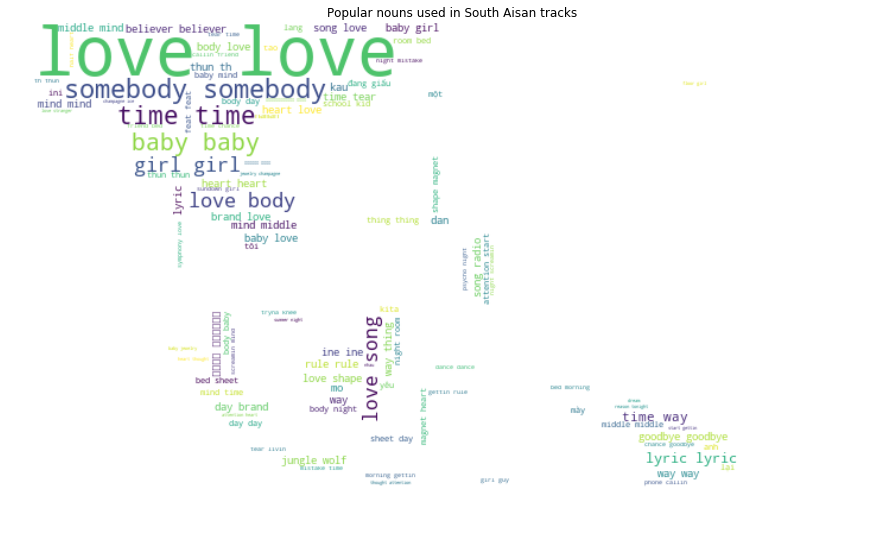

In [116]:
wc = WordCloud(background_color="white", max_words=500, mask=south_asia_mask,
        stopwords=spacy_stopwords, max_font_size = 60)
wc.generate(group_2_nouns)
image_colors = ImageColorGenerator(south_asia_mask)

plt.figure(figsize = (15,10))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.title('Popular nouns used in South Aisan tracks')
plt.show()

Apparently, **love** defintely is the most popular topic in music around the world. We saw a lot words relating to love songs showed up in all clusters' word cloud, for example, baby, girl, etc.

In the same time, we noticed that there are some common words in one clusters that didn't show up in other clusters. For instance, "bitch" is a popular word used in hip hop songs, which is popular in North America, but didn't show up in other two clusters' result.

In [117]:
group_0_adverbs = [word for sublist in list(group_0_lyrics['adverbs']) for word in sublist]
group_0_adverbs = ' '.join(group_0_adverbs)

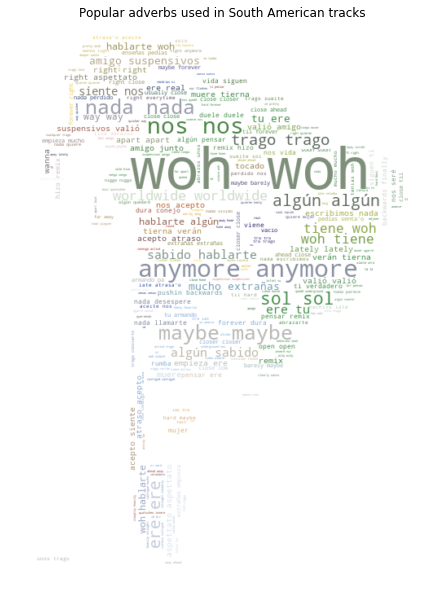

In [118]:
wc = WordCloud(background_color="white", max_words=400, mask=south_america_mask,
        stopwords=spacy_stopwords, max_font_size = 70)
wc.generate(group_0_adverbs )
image_colors = ImageColorGenerator(south_america_mask)

plt.figure(figsize = (10,10))
plt.axis("off")
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.title('Popular adverbs used in South American tracks')
plt.show()

South American tracks contains a lot of "woh" which might relates to the strong danceability of their songs.

In [119]:
group_1_adverbs = [word for sublist in list(group_1_lyrics['adverbs']) for word in sublist]
group_1_adverbs = ' '.join(group_1_adverbs)

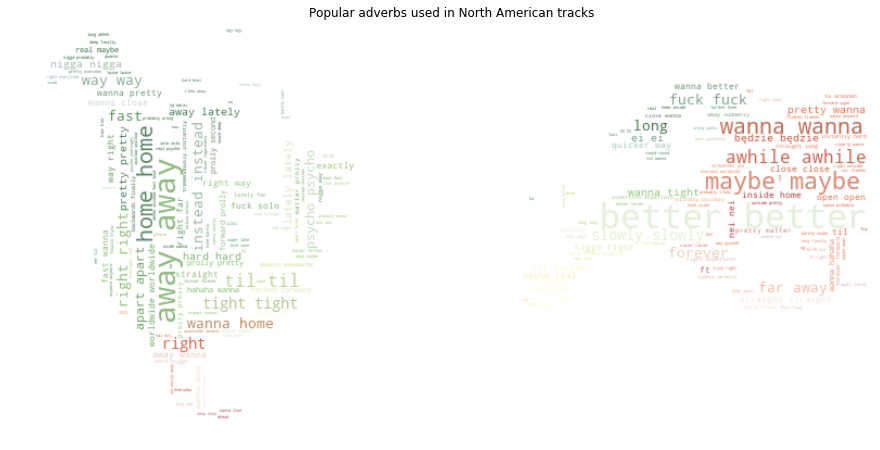

In [120]:
wc = WordCloud(background_color="white", max_words=800, mask=europe_mask,
        stopwords=spacy_stopwords, max_font_size = 70)
wc.generate(group_1_adverbs)
image_colors = ImageColorGenerator(europe_mask)

plt.figure(figsize = (15,10))
plt.axis("off")
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.title('Popular adverbs used in North American tracks')
plt.show()

In [121]:
group_2_adverbs = [word for sublist in list(group_2_lyrics['adverbs']) for word in sublist]
group_2_adverbs = ' '.join(group_2_adverbs)

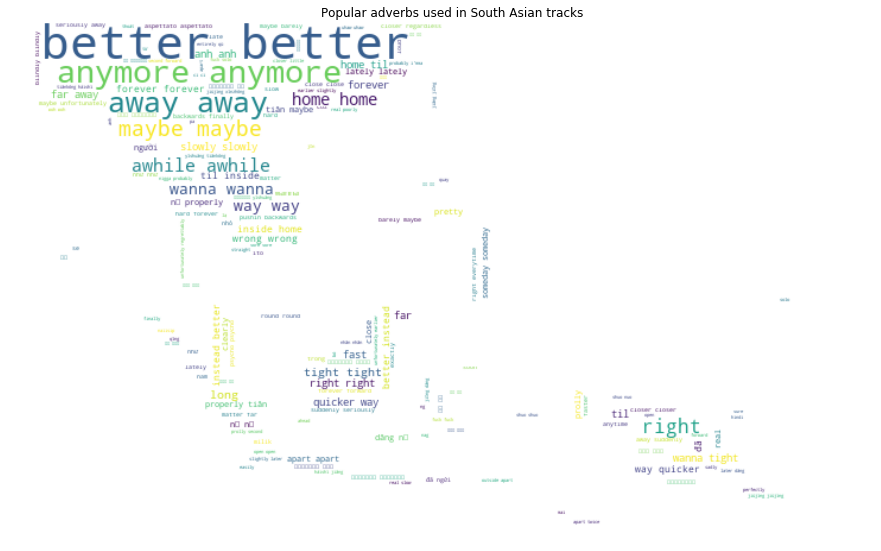

In [122]:
wc = WordCloud(background_color="white", max_words=500, mask=south_asia_mask,
        stopwords=spacy_stopwords, max_font_size = 60)
wc.generate(group_2_adverbs)
image_colors = ImageColorGenerator(south_asia_mask)

plt.figure(figsize = (15,10))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.title('Popular adverbs used in South Asian tracks')
plt.show()

## Top Artists

The following analysis analyze the top artists around the world as well as in specific areas. First, we will create a dataframe that countains top 50 artists who is popular in the country the frequency of an artist who is on the list.

**Frequency/Popularity** definition: if one artist appeared once in the top 200 songs in a country in a given week, increment the popularity by 1

In [42]:
df_artist = pd.DataFrame()
for country in countries:
    file_name = 'total_rank_data/' + country[0] + '.csv'
    temp = pd.read_csv(file_name)
    famous_song_series = temp[['Artist', 'spotify_id']]
    famous_song_df = pd.DataFrame({'Artist': famous_song_series['Artist'],
                                   'spotify_id': famous_song_series['spotify_id'],
                                   'Country': country[1]})
    famous_artist = famous_song_df['Artist'].value_counts()[:50]
    famous_artist_df = pd.DataFrame({'Artist': famous_artist.index, "Frequency": famous_artist.values, "Country": country[1]})
    df_artist = df_artist.append(famous_artist_df)

,Artist,Frequency,Country
0,Ozuna,45,Argentina
1,Duki,41,Argentina
2,Ed Sheeran,36,Argentina
3,Ariana Grande,31,Argentina
4,BTS,31,Argentina
...,...,...,...
45,Imagine Dragons,6,Vietnam
46,5 Seconds of Summer,6,Vietnam
47,Bebe Rexha,6,Vietnam
48,Lady Gaga,6,Vietnam


In [ ]:
df_artist.head()

Add up the all the frequency in individual country to create global popularity

In [45]:
df_global_fame = df_artist[["Artist", "Frequency"]].groupby("Artist").agg('sum').sort_values('Frequency', ascending=False)
df_global = pd.DataFrame({"Artist": df_global_fame.index, "Global Popularity": df_global_fame["Frequency"]})
df_global = df_global.reset_index(drop=True)
df_global[:20]

,Artist,Global Popularity
0,Drake,2049
1,Ed Sheeran,2017
2,Ariana Grande,1881
3,Post Malone,1585
4,BTS,1451
5,The Chainsmokers,1280
6,XXXTENTACION,1275
7,Linkin Park,1114
8,Eminem,1030
9,Taylor Swift,986


Based on cluster result, create popularity dataframe by cluster

In [46]:
df_cluster_1 = pd.DataFrame()
df_cluster_2 = pd.DataFrame()
df_cluster_3 = pd.DataFrame()
for index, row in df_artist.iterrows():
    if row['Country'] in cluster_1:
        df_cluster_1 = df_cluster_1.append(row)
    elif row['Country'] in cluster_2:
        df_cluster_2 = df_cluster_2.append(row)
    elif row['Country'] in cluster_3:
        df_cluster_3 = df_cluster_3.append(row)

Analyze cluster 1 which is the eroupe, NA, Oceania cluster

In [47]:
df_Euro_fame = df_cluster_1[["Artist", "Frequency"]].groupby("Artist").agg('sum').sort_values('Frequency', ascending=False)
df_Euro = pd.DataFrame({"Artist": df_Euro_fame.index, "Europe Popularity": df_Euro_fame["Frequency"]})
df_Euro = df_Euro.reset_index(drop=True)
df_Euro[:20]

,Artist,Europe Popularity
0,Drake,1376.0
1,Ed Sheeran,1181.0
2,Post Malone,1099.0
3,XXXTENTACION,1039.0
4,Ariana Grande,1012.0
5,Eminem,897.0
6,The Chainsmokers,794.0
7,Linkin Park,604.0
8,Travis Scott,593.0
9,Billie Eilish,575.0


Analyze cluster 2 which is the SA cluster

In [48]:
df_SA_fame = df_cluster_2[["Artist", "Frequency"]].groupby("Artist").agg('sum').sort_values('Frequency', ascending=False)
df_SA = pd.DataFrame({"Artist": df_SA_fame.index, "South America Popularity": df_SA_fame["Frequency"]})
df_SA = df_SA.reset_index(drop=True)
df_SA[:20]

,Artist,South America Popularity
0,Ozuna,766.0
1,Bad Bunny,492.0
2,J Balvin,456.0
3,Ariana Grande,453.0
4,Ed Sheeran,438.0
5,BTS,435.0
6,Maluma,381.0
7,Drake,375.0
8,Paulo Londra,332.0
9,Sebastian Yatra,282.0


Analyze cluster 3 which is the Asia cluster

In [49]:
df_Asia_fame = df_cluster_3[["Artist", "Frequency"]].groupby("Artist").agg('sum').sort_values('Frequency', ascending=False)
df_Asia = pd.DataFrame({"Artist": df_Asia_fame.index, "Asia Popularity": df_Asia_fame["Frequency"]})
df_Asia = df_Asia.reset_index(drop=True)
df_Asia[:20]

,Artist,Asia Popularity
0,BTS,427.0
1,Ariana Grande,285.0
2,Ed Sheeran,273.0
3,The Chainsmokers,251.0
4,Linkin Park,248.0
5,Taylor Swift,245.0
6,Post Malone,185.0
7,Drake,174.0
8,Camila Cabello,158.0
9,BLACKPINK,158.0


Develop a big table containing each composition of popularity accross areas

In [50]:
df_percentile = df_global.merge(df_Euro, on="Artist", how="left")
df_percentile = df_percentile.merge(df_SA, on="Artist", how="left")
df_percentile = df_percentile.merge(df_Asia, on="Artist", how="left")
df_percentile = df_percentile.fillna(0)

Create percentile representation of artists popularity breakdown by areas

In [51]:
df_percentile['Europe Percent'] = round(df_percentile["Europe Popularity"]\
                                        / df_percentile["Global Popularity"], 4)
df_percentile['SA Percent'] = round(df_percentile["South America Popularity"] / df_percentile["Global Popularity"], 4)
df_percentile['Asia Percent'] = round(df_percentile["Asia Popularity"] / df_percentile["Global Popularity"], 4)
df_percentile['Other Percent'] = round((df_percentile["Global Popularity"]\
                                        -df_percentile["Europe Popularity"]\
                                        -df_percentile["South America Popularity"]\
                                        -df_percentile["Asia Popularity"])\
                                        / df_percentile["Global Popularity"], 4)
df_percentile[:10]

,Artist,Global Popularity,Europe Popularity,South America Popularity,Asia Popularity,Europe Percent,SA Percent,Asia Percent,Other Percent
0,Drake,2049,1376.0,375.0,174.0,0.6715,0.1830,0.0849,0.0605
1,Ed Sheeran,2017,1181.0,438.0,273.0,0.5855,0.2172,0.1353,0.0620
2,Ariana Grande,1881,1012.0,453.0,285.0,0.5380,0.2408,0.1515,0.0696
3,Post Malone,1585,1099.0,221.0,185.0,0.6934,0.1394,0.1167,0.0505
4,BTS,1451,469.0,435.0,427.0,0.3232,0.2998,0.2943,0.0827
5,The Chainsmokers,1280,794.0,164.0,251.0,0.6203,0.1281,0.1961,0.0555
6,XXXTENTACION,1275,1039.0,147.0,42.0,0.8149,0.1153,0.0329,0.0369
7,Linkin Park,1114,604.0,194.0,248.0,0.5422,0.1741,0.2226,0.0610
8,Eminem,1030,897.0,9.0,65.0,0.8709,0.0087,0.0631,0.0573
9,Taylor Swift,986,504.0,168.0,245.0,0.5112,0.1704,0.2485,0.0700


Create a list of pairs that marks different level of popularity with corresponding number of artists

In [52]:
# divide intervals to count the number of artists in the interval
ranges = [0,30,80,200,500,1000,2000,2500]
popularity_chart = df_percentile["Artist"].groupby(pd.cut(df_percentile["Global Popularity"], ranges)).count()
temp_array = list(popularity_chart.values)
# reverse the array to do addition
temp_array = temp_array[::-1]
for i in range(1, len(temp_array)):
    temp_array[i] = temp_array[i] + temp_array[i-1]
# construct pairs of popularity & number of singers
popularity_fact = list(zip(temp_array, ranges[:-1][::-1]))[:-1]
popularity_fact

[(2, 2000), (9, 1000), (22, 500), (54, 200), (122, 80), (281, 30)]

Plot the popularity vs the number of the artists in the category

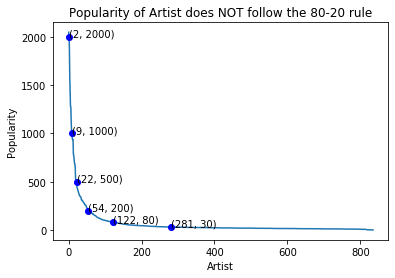

In [53]:
plt.plot(df_percentile["Global Popularity"])
for item in popularity_fact:
    plt.plot(item[0], item[1], 'bo')
    plt.annotate("(" + str(item[0]) + ", " + str(item[1]) + ")", (item[0], item[1]))
plt.ylabel('Popularity')
plt.xlabel('Artist')
plt.title("Popularity of Artist does NOT follow the 80-20 rule")
plt.show()

This plot shows the sharp decrease in popularity as the number of artist increases, indicating the popularity of artists does not follow the 80 20 rule. There are a few top and most telented artists in the market with a lot of average artists who has far less popularity. 

In [55]:
df_graph = df_percentile[["Artist", "Global Popularity", "Europe Percent", "SA Percent", "Asia Percent", 'Other Percent']]
df_graph

,Artist,Global Popularity,Europe Percent,SA Percent,Asia Percent,Other Percent
0,Drake,2049,0.6715,0.1830,0.0849,0.0605
1,Ed Sheeran,2017,0.5855,0.2172,0.1353,0.0620
2,Ariana Grande,1881,0.5380,0.2408,0.1515,0.0696
3,Post Malone,1585,0.6934,0.1394,0.1167,0.0505
4,BTS,1451,0.3232,0.2998,0.2943,0.0827
...,...,...,...,...,...,...
831,JP Cooper,1,1.0000,0.0000,0.0000,0.0000
832,Cheat Codes,1,1.0000,0.0000,0.0000,0.0000
833,Louis Tomlinson,1,1.0000,0.0000,0.0000,0.0000
834,Sigala,1,1.0000,0.0000,0.0000,0.0000


Select some sample artists and draw pie graphs to visualize their influence by area

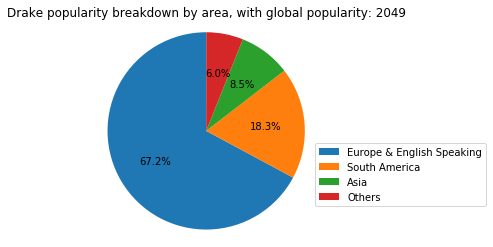

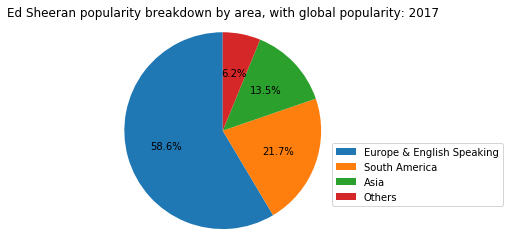

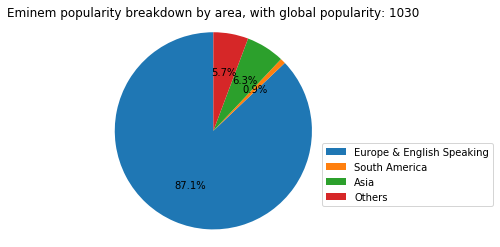

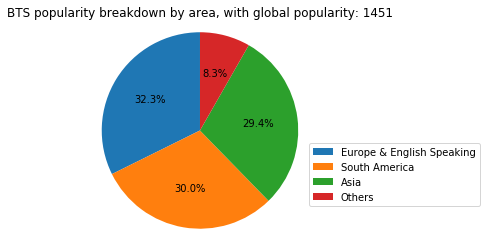

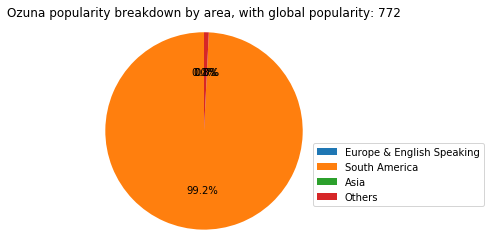

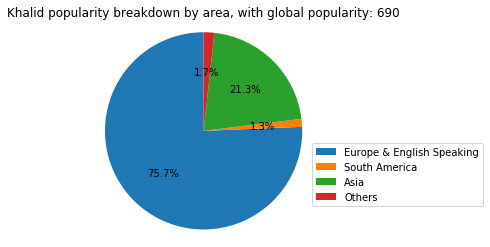

In [56]:
singers = ['Drake', 'Ed Sheeran', 'Eminem', 'BTS', 'Ozuna', 'Khalid']
labels = ["Europe & English Speaking", "South America", "Asia", "Others"]
for singer in singers:
    array = np.array(df_graph[df_graph['Artist'] == singer])
    ploting = array[0][2:]
    plt.pie(ploting, autopct='%1.1f%%', startangle=90)
    plt.title(array[0][0] + " popularity breakdown by area, with global popularity: " + str(array[0][1]))
    plt.legend(labels, loc="right", bbox_to_anchor=(1.35, 0.3))
    plt.axis('equal') 
    plt.show()

This visualzation shows that even the most popular artists, there is significant difference in their influence in individual areas

In [57]:
df_percentile["Other Popularity"] = df_percentile["Global Popularity"]\
                                    - df_percentile["Europe Popularity"]\
                                    - df_percentile["South America Popularity"]\
                                    - df_percentile["Asia Popularity"]
df_percentile[:10]

,Artist,Global Popularity,Europe Popularity,South America Popularity,Asia Popularity,Europe Percent,SA Percent,Asia Percent,Other Percent,Other Popularity
0,Drake,2049,1376.0,375.0,174.0,0.6715,0.1830,0.0849,0.0605,124.0
1,Ed Sheeran,2017,1181.0,438.0,273.0,0.5855,0.2172,0.1353,0.0620,125.0
2,Ariana Grande,1881,1012.0,453.0,285.0,0.5380,0.2408,0.1515,0.0696,131.0
3,Post Malone,1585,1099.0,221.0,185.0,0.6934,0.1394,0.1167,0.0505,80.0
4,BTS,1451,469.0,435.0,427.0,0.3232,0.2998,0.2943,0.0827,120.0
5,The Chainsmokers,1280,794.0,164.0,251.0,0.6203,0.1281,0.1961,0.0555,71.0
6,XXXTENTACION,1275,1039.0,147.0,42.0,0.8149,0.1153,0.0329,0.0369,47.0
7,Linkin Park,1114,604.0,194.0,248.0,0.5422,0.1741,0.2226,0.0610,68.0
8,Eminem,1030,897.0,9.0,65.0,0.8709,0.0087,0.0631,0.0573,59.0
9,Taylor Swift,986,504.0,168.0,245.0,0.5112,0.1704,0.2485,0.0700,69.0


Visualize the top 15 artists and their population breakdown in geographical areas

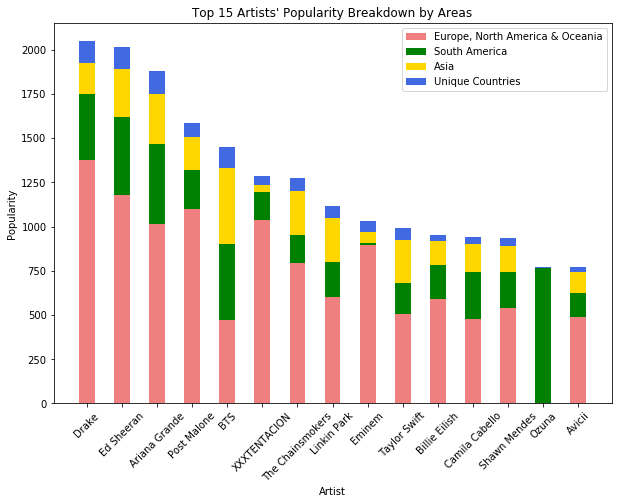

In [76]:
plt.figure(figsize=(10,7))
N = 15
Europe = df_percentile["Europe Popularity"][:15]
SA =  df_percentile["South America Popularity"][:15]
Asia = df_percentile["Asia Popularity"][:15]
Other =  df_percentile["Other Popularity"][:15]
ind = np.arange(N)    # the x locations for the groups
width = 0.45       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, Europe, width, label="Europe, North America & Oceania", color='lightcoral')
p2 = plt.bar(ind, SA, width, bottom=Europe, label="South America", color='green')
p3 = plt.bar(ind, Asia, width, bottom=Europe+SA, label="Asia", color='gold')
p4 = plt.bar(ind, Other, width, bottom=Europe+SA+Asia, label="Unique Countries", color='royalblue')

plt.ylabel('Popularity')
plt.xlabel('Artist')
plt.title("Top 15 Artists' Popularity Breakdown by Areas")
plt.xticks(ind, df_percentile["Artist"][:15], rotation=45)
plt.legend(prop={'size': 10})

From this graph we could also observe the difference in artists influence in individual area. The height of the graph give reader more sence about the global popularity of the artists.

## Summary

From our analysis, we found out that music taste of people in different **geographic areas** varies while some characteristics of music are **universal**. To summerize, there are four key findings:

- Major geograpich difference: Geographic continent is the best indicator of what type of music people like.
- Different music taste: South American prefer energetic and happy music while Asian are more likely to listen relaxing and mellow songs.
- Similar music features: Tracks with key in C or C-sharp and topic in love are popular around the world.
- Global popular artist: Popular artist should find the balance between regional preference and global love to become a global popular artist.

In the meantime, we have to keep in mind there are some **limitations** in our project. The applicability of this analysis is limited to English songs in countries that Spotify is widely used. To get a better understanding of music taste for the entire world, we should obtain data from multiple music platforms.

#### Hope you enjoyed our analysis!